In [1]:
import pandas as pd
from scipy.stats import wilcoxon
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load ranked analysis with domains

ranked_df = pd.read_csv('./results/ranked_analysis_with_domains.csv', sep=',')
ranked_df

,result id,original,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,search term,domain
0,S-EPMC6040727,1.5,1.333333,1.333333,1.2,0.000000,0.000000,1.333333,1.333333,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,AIDS,immunology
1,Mendeley_pzp26k9fy7,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.400000,1.400000,0.000000,0.0,0.0,0.000000,0.000000,AIDS,immunology
2,DRYAD_doi.org:10.5061:dryad.9r35r,0.0,0.000000,3.666667,11.0,22.000000,11.000000,0.000000,7.333333,22.0,22.000000,22.000000,2.444444,11.0,22.0,22.000000,22.000000,AIDS,immunology
3,veupathdb_DS_e8c4cf2187,0.0,0.000000,0.000000,0.0,2.200000,3.666667,0.000000,0.000000,0.0,1.833333,3.666667,0.000000,0.0,0.0,0.000000,1.100000,AIDS,immunology
4,Dataverse_10.5064_F6SF2T3N,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.857143,2.166667,0.000000,0.0,0.0,2.600000,4.333333,AIDS,immunology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,ZENODO_5044544,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.300000,1.625000,zika microcephaly,infectious disease
477,ZENODO_5008681,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.700000,zika microcephaly,infectious disease
478,S-EPMC6256666,1.7,1.700000,0.000000,0.0,0.000000,0.000000,1.700000,0.000000,0.0,0.000000,0.000000,1.700000,0.0,0.0,0.000000,0.000000,zika microcephaly,infectious disease
479,IMMPORT_SDY1515_2,0.0,0.000000,0.000000,0.0,6.333333,9.500000,0.000000,0.000000,0.0,3.800000,9.500000,0.000000,0.0,0.0,2.375000,3.800000,sublingual immunotherapy,allergy


In [3]:
combination_order = ['original', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6',
                     'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13',
                     'c14', 'c15']

In [4]:
def compute_scores(df, combination_order):
    final_df = pd.DataFrame()

    for combi in combination_order:
        df_comb = df[['search term', combi]].copy()
        df_comb_sum = df_comb.groupby('search term').sum().reset_index()
        if final_df.empty:
            final_df = df_comb_sum
        else: 
            final_df = final_df.merge(df_comb_sum, on = 'search term')

    final_df.columns = ['search term'] + combination_order
    return final_df

In [5]:
def perform_wilcoxon_test(data):
    data = data.drop('search term', axis = 1)
    # Get the column names
    columns = data.columns
    
    # Initialize a list to hold the results
    results = []
    
    # Perform the Wilcoxon signed-rank test for each pair of columns
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            col1 = columns[i]
            col2 = columns[j]
            stat, p = wilcoxon(data[col1], data[col2])
            results.append((col1, col2, stat, p))
            
    # Create a DataFrame from the results
    results_df = pd.DataFrame(results, columns=['set 1', 'set 2', 'statistic', 'p-value'])
    return results_df

In [6]:
def compare_scores(scores, columns):
    score_comparisons = {}
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            set1 = columns[i]
            set2 = columns[j]
            if scores[set1] > scores[set2]:
                score_comparisons[(set1, set2)] = set1
            else:
                score_comparisons[(set1, set2)] = set2
    return score_comparisons

In [7]:
def add_winner(row):
    set1, set2 = row['set 1'], row['set 2']
    return winners[(set1, set2)]

In [8]:
def swap_sets(row):
    s1_index = combination_order.index(row['set 1'])
    s2_index = combination_order.index(row['set 2'])
    if s2_index < s1_index:
        return pd.Series([row['set 1'], row['set 2'], row['p-value']])  
    else:
        return pd.Series([row['set 2'], row['set 1'], row['p-value']])

In [9]:
def create_heatmap_with_winners(df, title, filename):
    heatmap_data = df.pivot('set 1', 'set 2', 'p-value')

    # Reorder index and columns
    heatmap_data = heatmap_data.reindex(combination_order, axis = 0)
    heatmap_data = heatmap_data.reindex(combination_order, axis = 1)

    # Combine winner and p-value in the annotation
    formatted_text = np.empty(heatmap_data.shape, dtype = object)
    
    for i in range(len(combination_order)):
        for j in range(len(combination_order)):
            if not np.isnan(heatmap_data.iloc[i, j]):
                formatted_text[i, j] = "{}\n{:.3f}".format(df[(df['set 1'] == combination_order[i]) & (df['set 2'] == combination_order[j])]['winner'].values[0], df[(df['set 1'] == combination_order[i]) & (df['set 2'] == combination_order[j])]['p-value'].values[0])
        else:
            formatted_text[i, j] = ""

    # Create heatmap using seaborn
    sns.set(font_scale = 1.4)
    sns.set_style('white')
    plt.figure(figsize = (24, 12))
    sns.heatmap(heatmap_data, cmap='BuPu_r', annot=formatted_text, fmt="", cbar_kws={'label': 'p-values'})
    plt.savefig(f'../alternate_test/results/{filename}.png', dpi = 150, bbox_inches = 'tight')
    plt.show()

In [10]:
immunology_ranked_df = ranked_df.loc[ranked_df['domain'] == 'immunology']
immunology_ranked_df

,result id,original,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,search term,domain
0,S-EPMC6040727,1.500000,1.333333,1.333333,1.200000,0.000000,0.000000,1.333333,1.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,AIDS,immunology
1,Mendeley_pzp26k9fy7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.400000,1.400000,0.000000,0.000000,0.000000,0.000000,0.000000,AIDS,immunology
2,DRYAD_doi.org:10.5061:dryad.9r35r,0.000000,0.000000,3.666667,11.000000,22.000000,11.000000,0.000000,7.333333,22.000000,22.000000,22.000000,2.444444,11.000000,22.000000,22.000000,22.000000,AIDS,immunology
3,veupathdb_DS_e8c4cf2187,0.000000,0.000000,0.000000,0.000000,2.200000,3.666667,0.000000,0.000000,0.000000,1.833333,3.666667,0.000000,0.000000,0.000000,0.000000,1.100000,AIDS,immunology
4,Dataverse_10.5064_F6SF2T3N,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.857143,2.166667,0.000000,0.000000,0.000000,2.600000,4.333333,AIDS,immunology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,S-EPMC1783452,7.333333,7.333333,7.333333,5.500000,0.000000,0.000000,7.333333,7.333333,5.500000,2.444444,0.000000,7.333333,7.333333,7.333333,3.142857,0.000000,t-cell function,immunology
396,GSE175941,0.000000,0.000000,2.250000,6.000000,18.000000,9.000000,0.000000,2.250000,6.000000,18.000000,9.000000,0.000000,2.000000,3.600000,9.000000,9.000000,t-cell function,immunology
397,S-EPMC2950556,11.000000,11.000000,11.000000,11.000000,2.750000,0.000000,11.000000,11.000000,11.000000,3.666667,0.000000,11.000000,11.000000,11.000000,5.500000,2.200000,t-cell function,immunology
418,S-EPMC1478197,21.000000,21.000000,21.000000,21.000000,3.500000,0.000000,21.000000,21.000000,21.000000,4.200000,0.000000,21.000000,21.000000,21.000000,7.000000,3.000000,t-cell function,immunology


In [11]:
# Calculate scores per search term per combination

immunology_scores_df = compute_scores(immunology_ranked_df, combination_order)
immunology_scores_df

,search term,original,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
0,AIDS,48.323016,47.992857,49.611905,52.412302,52.680159,48.588492,47.892857,51.427381,53.659127,52.012698,50.191270,48.938492,52.681746,52.825397,50.786508,50.107937
1,addison's disease,46.199206,46.199206,46.599206,45.584921,45.551587,46.501587,46.199206,46.596825,45.918254,45.551587,46.534921,46.199206,46.596825,46.501587,45.551587,46.534921
2,immunotherapeutics,57.660317,57.660317,57.760317,57.760317,57.760317,57.760317,57.660317,57.660317,57.760317,57.760317,57.760317,57.660317,57.660317,57.760317,57.760317,57.831746
3,t-cell function,56.685714,61.866270,61.513492,58.612302,50.143651,44.270635,61.866270,61.513492,59.763492,51.040873,45.418651,61.866270,61.610714,59.205159,47.748413,45.925000


In [12]:
# Run Wilcoxon test

immunology_wilcoxon_df = perform_wilcoxon_test(immunology_scores_df)
immunology_wilcoxon_df

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,set 1,set 2,statistic,p-value
0,original,c1,1.0,0.654721
1,original,c2,0.0,0.125000
2,original,c3,2.0,0.375000
3,original,c4,4.0,0.875000
4,original,c5,4.0,0.875000
...,...,...,...,...
115,c12,c14,1.0,0.250000
116,c12,c15,2.0,0.375000
117,c13,c14,0.0,0.108809
118,c13,c15,3.0,0.625000


In [13]:
# Export scores per search term

immunology_scores_df.to_csv('../alternate_test/results/scores_immunology.csv', index = False)

In [14]:
# Drop search term column

immunology_scores_only_df = immunology_scores_df.drop(columns = ['search term'])
immunology_scores_only_df

,original,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
0,48.323016,47.992857,49.611905,52.412302,52.680159,48.588492,47.892857,51.427381,53.659127,52.012698,50.191270,48.938492,52.681746,52.825397,50.786508,50.107937
1,46.199206,46.199206,46.599206,45.584921,45.551587,46.501587,46.199206,46.596825,45.918254,45.551587,46.534921,46.199206,46.596825,46.501587,45.551587,46.534921
2,57.660317,57.660317,57.760317,57.760317,57.760317,57.760317,57.660317,57.660317,57.760317,57.760317,57.760317,57.660317,57.660317,57.760317,57.760317,57.831746
3,56.685714,61.866270,61.513492,58.612302,50.143651,44.270635,61.866270,61.513492,59.763492,51.040873,45.418651,61.866270,61.610714,59.205159,47.748413,45.925000


In [15]:
# Compute total scores per combination

immunology_total_scores_df = immunology_scores_only_df.sum()
immunology_total_scores_df

original    208.868254
c1          213.718651
c2          215.484921
c3          214.369841
c4          206.135714
c5          197.121032
c6          213.618651
c7          217.198016
c8          217.101190
c9          206.365476
c10         199.905159
c11         214.664286
c12         218.549603
c13         216.292460
c14         201.846825
c15         200.399603
dtype: float64

In [16]:
# Determine winners by comparing combination scores

winners = compare_scores(immunology_total_scores_df, combination_order)
winners

{('original', 'c1'): 'c1',
 ('original', 'c2'): 'c2',
 ('original', 'c3'): 'c3',
 ('original', 'c4'): 'original',
 ('original', 'c5'): 'original',
 ('original', 'c6'): 'c6',
 ('original', 'c7'): 'c7',
 ('original', 'c8'): 'c8',
 ('original', 'c9'): 'original',
 ('original', 'c10'): 'original',
 ('original', 'c11'): 'c11',
 ('original', 'c12'): 'c12',
 ('original', 'c13'): 'c13',
 ('original', 'c14'): 'original',
 ('original', 'c15'): 'original',
 ('c1', 'c2'): 'c2',
 ('c1', 'c3'): 'c3',
 ('c1', 'c4'): 'c1',
 ('c1', 'c5'): 'c1',
 ('c1', 'c6'): 'c1',
 ('c1', 'c7'): 'c7',
 ('c1', 'c8'): 'c8',
 ('c1', 'c9'): 'c1',
 ('c1', 'c10'): 'c1',
 ('c1', 'c11'): 'c11',
 ('c1', 'c12'): 'c12',
 ('c1', 'c13'): 'c13',
 ('c1', 'c14'): 'c1',
 ('c1', 'c15'): 'c1',
 ('c2', 'c3'): 'c2',
 ('c2', 'c4'): 'c2',
 ('c2', 'c5'): 'c2',
 ('c2', 'c6'): 'c2',
 ('c2', 'c7'): 'c7',
 ('c2', 'c8'): 'c8',
 ('c2', 'c9'): 'c2',
 ('c2', 'c10'): 'c2',
 ('c2', 'c11'): 'c2',
 ('c2', 'c12'): 'c12',
 ('c2', 'c13'): 'c13',
 ('c2', 'c

In [17]:
# Add winners to Wilcoxon test results

immunology_wilcoxon_df['winner'] = immunology_wilcoxon_df.apply(add_winner, axis = 1)
immunology_wilcoxon_df

,set 1,set 2,statistic,p-value,winner
0,original,c1,1.0,0.654721,c1
1,original,c2,0.0,0.125000,c2
2,original,c3,2.0,0.375000,c3
3,original,c4,4.0,0.875000,original
4,original,c5,4.0,0.875000,original
...,...,...,...,...,...
115,c12,c14,1.0,0.250000,c12
116,c12,c15,2.0,0.375000,c12
117,c13,c14,0.0,0.108809,c13
118,c13,c15,3.0,0.625000,c13


In [18]:
immunology_wilcoxon_df['winner'].value_counts()

c12         15
c7          14
c8          13
c13         12
c2          11
c11         10
c3           9
c1           8
c6           7
original     6
c9           5
c4           4
c14          3
c15          2
c10          1
Name: winner, dtype: int64

In [19]:
immunology_wilcoxon_df[immunology_wilcoxon_df['p-value'] <= 0.05]

,set 1,set 2,statistic,p-value,winner


In [20]:
# Export Wilcoxon test results

immunology_wilcoxon_df.to_csv('../alternate_test/results/wilcoxon_with_winners_immunology.csv', index = False)

In [21]:
# Rearrange rows so that heatmap cells are rendered below the main diagonal

immunology_wilcoxon_df[['set 1', 'set 2', 'p-value']] = immunology_wilcoxon_df.apply(swap_sets, axis = 1)

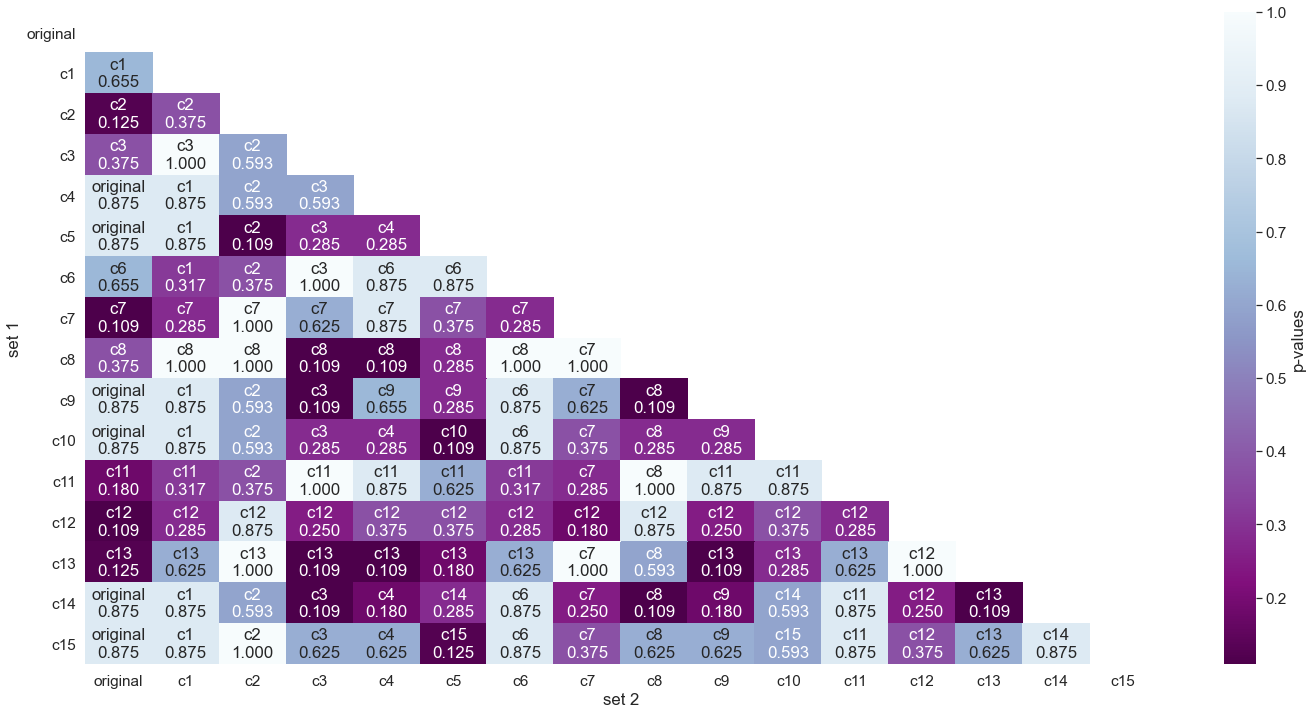

In [22]:
# Generate heatmap of p-values with winners

create_heatmap_with_winners(immunology_wilcoxon_df, 'Heatmap of p-values | Wilcoxon test', 
                            'wilcoxon_heatmap_with_winners_immunology')